## Data and Code for AAAI-AIA  Submission 124

### Data and Experimental Results

We include data of our experiments under the directory 'data' in this folder, which include three subfolders:
1. 'predictions' contains all the predictions of all instances from the models as well as the ground truth;
2. 'values_for_metrics' contains all the alignment score we measure between each pair of models in different datasets;
3. 'correlations' contains the spearman's R between each pair of measurements in each dataset.

In [1]:
import functional.utils as utils
import pandas as pd
import numpy as np
import os
import torch
from torchmetrics.regression import KLDivergence

The code below sets the dataset and some prediction systems for the later evaluation. To modify the dataset on which these are evaluated, change the variable 'dataset' to one of the following 'image_net_a', 'mpii_cooking', 'epic_kitchen', 'modelvshuman/{specific distortion}'. You must then modify the number of classes 'k' to the appropriate values (see inline comments in the code).

Choices for two systems are made by appropriately setting variables 'agent_1' and 'agent_2'. Valid values are those models listed in the Appendix such as 'resnet101', 'inception' for image dataset. 

In [2]:
prediction_path = 'data/predictions/'
dataset = 'image_net_a' # 'mpii_cooking' with k=87 ; epic_kitchen with k=97; each subset in modelvshuman with k=16
k = 200
labels = [i for i in range(k)]

agent_1 = 'resnet101'
agent_2 = 'inception'

true_cls = np.load(f'{prediction_path}/{dataset}/true_cls.npy')
pred_1 = np.load(f'{prediction_path}/{dataset}/{agent_1}.npy')
pred_2 = np.load(f'{prediction_path}/{dataset}/{agent_2}.npy')

### Misclassification Agreement

In [3]:
def get_ma(true_cls, pred_1, pred_2, k):
    """
    Get the multiclass agreement for a pair of predictors
    Parameters
    ----------
    true_cls: the ground truth classes (1d numpy array)
    pred_1: the predicted results for predictor 1 (1d numpy array)
    pred_2: the predicted results for predictor 2 (1d numpy array)
    k: the number of classes

    Returns ma value, c_observe, c_expectation
    -------
    """
    a_mat = utils.generate_error_agreement(np.array(true_cls), np.array(pred_1), np.array(pred_2), k)
    total_num = np.sum(a_mat)
    pis = np.sum(a_mat, axis=1) / total_num
    pjs = np.sum(a_mat, axis=0) / total_num
    cexp = 0
    for pi, pj in zip(pis, pjs):
        cexp += pi*pj
    cobse = np.trace(a_mat) / total_num
    ma = (cobse-cexp)/(1-cexp)
    return ma, cobse, cexp

In [4]:
ma, _, _ = get_ma(true_cls, pred_1, pred_2, k)
print(f'the Misclassification Agreement between {agent_1} and {agent_2} is {ma}')

the Misclassification Agreement between resnet101 and inception is 0.3249500206107583


### Class-Level Error Similarity

In [5]:
def get_row_wise_div(conf_emat1, conf_emat2, k, alpha=0.5, weighted=False):
    n_0 = []
    divs = []
    kld = KLDivergence()

    for i, (a, b) in enumerate(zip(conf_emat1, conf_emat2)):
        ai = np.delete(a, i)
        n_ai = np.sum(ai)
        pi_ai = (ai+alpha) / (n_ai+(k-1)*alpha) 
        bi = np.delete(b, i)
        n_bi = np.sum(bi)
        pi_bi = (bi+alpha) / (n_bi+(k-1)*alpha)
        n_0i = n_ai + n_bi
        pi_0i = (ai + bi +alpha) / (n_ai + n_bi + (k-1)*alpha) 
        if n_0i == 0:
            div = 0
        else:
            kld_10 = kld(torch.tensor([pi_ai]), torch.tensor([pi_0i])).item()
            kld_20 = kld(torch.tensor([pi_bi]), torch.tensor([pi_0i])).item()
            if weighted:
                div = (n_ai / n_0i) * kld_10 + (n_bi / n_0i) * kld_20
            else:
                div = (1/2) * kld_10 + (1/2) * kld_20

        n_0.append(n_0i)
        divs.append(div)

    overall_div = np.sum(np.multiply(n_0 / np.sum(n_0), divs))
    return overall_div, divs, n_0

In [6]:
conf_emat1 = utils.get_confusion_errors(true_cls, pred_1, labels)
conf_emat2 = utils.get_confusion_errors(true_cls, pred_2, labels)
div, _, _ = get_row_wise_div(conf_emat1, conf_emat2, k)
cles = 1 / (1 + div)
print(f'the Class-Level Error Similarity between {agent_1} and {agent_2} is {cles}')

the Class-Level Error Similarity between resnet101 and inception is 0.9301440836457868


C:\Users\xubinxia\AppData\Local\Temp\ipykernel_204\3551705519.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  kld_10 = kld(torch.tensor([pi_ai]), torch.tensor([pi_0i])).item()


### Correlation between MA and CLES for a dataset

In [7]:
def get_div_for_all_pair(class_assignments, agent_list1, agent_list2, true_cls, k, weighted=False):
    # get div values for each pair of agent 
    all_div = np.empty([len(agent_list1), len(agent_list2)])
    labels = [i for i in range(k)]
    for i, agent_1 in enumerate(agent_list1):
        conf_emat1 = utils.get_confusion_errors(true_cls, class_assignments[agent_1], labels)
        for j, agent_2 in enumerate(agent_list2):
            conf_emat2 = utils.get_confusion_errors(true_cls, class_assignments[agent_2], labels)
            div, _ ,_ = get_row_wise_div(conf_emat1, conf_emat2, k, weighted=weighted)
            all_div[i][j] = div
    return np.array(all_div)


def get_ma_for_all_pair(class_assignments, agent_list1, agent_list2, true_cls, k):
    # get ma values for each pair of agent 
    mas = np.zeros((len(agent_list1), len(agent_list2)), dtype=float)
    for i, agent_1 in enumerate(agent_list1):
        pred_1 = class_assignments[agent_1]
        for j, agent_2 in enumerate(agent_list2):
            pred_2 = class_assignments[agent_2]
            mas[i][j], _, _ = get_ma(true_cls, pred_1, pred_2, k)
            if np.isnan(mas[i][j]):
                mas[i][j] = 1
    return np.array(mas)

def get_off_diagonal_values(mat):
    return [mat[i][j] for j in range(mat.shape[1]) for i in range(mat.shape[0]) if j > i]

In [8]:
agent_list = ['vgg11', 'vgg13', 'vgg16', 'vgg19', 'resnet18', 'resnet50', 'resnet101', 'resnet152',
          'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception',  
          'vit_b_16', 'vit_b_32', 'vit_l_16', 'vit_l_32', 'swin_t', 'swin_b', 'swin_s',
          'clip_v', 'noisy_student']
true_cls = np.load(f'data/predictions/{dataset}/true_cls.npy')
class_assignments = {}
for agent in agent_list:
    ifname = f'data/predictions/{dataset}/{agent}.npy'
    pred = np.load(ifname)
    class_assignments[agent] = pred
divs = get_div_for_all_pair(class_assignments, agent_list, agent_list, true_cls, k)
cleses = 1 / (1 + divs)
mas = get_ma_for_all_pair(class_assignments, agent_list, agent_list, true_cls, k)

Plotting the paired metrics for MA and CLES for all pairs of models in image_net_a


Text(0.5, 1.0, 'image_net_a')

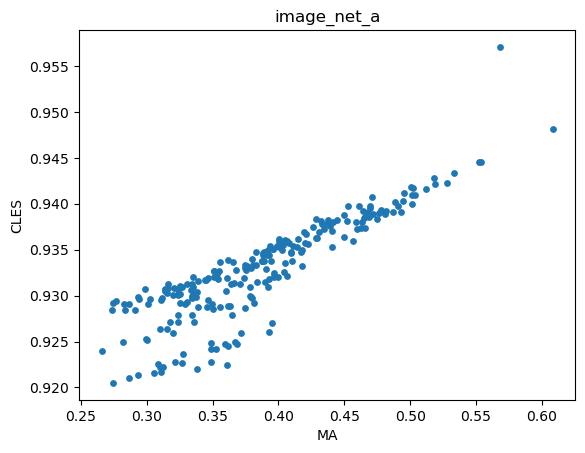

In [9]:
import matplotlib.pyplot as plt

print(f'Plotting the paired metrics for MA and CLES for all pairs of models in {dataset}')

plt.scatter(get_off_diagonal_values(mas), get_off_diagonal_values(cleses), s=15)
plt.xlabel('MA')
plt.ylabel('CLES')
plt.title(f'{dataset}')